In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda
import pycomplexes
import yaml
import pandas as pd

# Generate test trajectory

The first step is to generate a test trajectory with known distances between two beads. Using this trajectory and the rerun options in complexes we can easily test the energy functions.

In [2]:
xyz = np.zeros((1000, 2, 3))
xyz[:, 0, 0] = np.linspace(.01, 5, 1000)
xyz += 10
box = np.eye(3) * 100
with mda.lib.formats.libmdaxdr.TRRFile('test.trr', 'w') as xtc:
    for i, x in enumerate(xyz):
        # convert to nanometer before saving
        xtc.write(x / 10, None, None, box, i, i, 0, 2)
x = xyz[:, 0, 0] - 10

Now we should also have a PDB with four beads for this

In [3]:
u = mda.Universe.empty(2, n_residues=2, atom_resindex=[0, 1], trajectory=True)

u.add_TopologyAttr('names', np.array(['CA', 'CA']))
u.add_TopologyAttr('resnames', np.array(['ALA', 'EM']))
u.add_TopologyAttr('resids', np.array([1, 2]))
u.atoms.dimensions = mda.lib.mdamath.triclinic_box(*box)
u.atoms.write('test.gro')

# Generate a CPLX file to use

We write this by hand to make our live easier

In [4]:
%%writefile test.cplx
box: [100, 100, 100]
definitions:
  domains:
    A:
      defaults: {rotation: 2, translation: 1}
      move: rigid
    EM:
      defaults: {rotation: 2, translation: 1}
      move: rigid
  pair-interaction:
  - domain-type-pair: [A, EM]
    function: Softcore
  - domain-type-pair: [A, A]
    function: None
  - domain-type-pair: [EM, EM]
    function: None
topologies:
- connections: []
  domains:
    0:
      beads: [EM]
      chain-ids: [A 2]
      charges: [1.0]
      coordinates:
      - [0.0, 0.0, 0.0]
      mc-moves: {}
      meta-data: {}
      name: EM
      nbeads: 1
      type: EM
    1:
      beads: [ALA]
      chain-ids: [A 1]
      charges: [1.0]
      coordinates:
      - [0.0, 0.0, 0.0]
      mc-moves: {}
      meta-data: {}
      name: protein
      nbeads: 1
      type: A
  name: test
  ndomains: 2
forcefield:
  alpha: 0.5
  dielectric-constant: 80
  debye-length: 10
  bead-types:
    - ALA
    - EM
  charge-radii:
    ALA : 1
    EM : 1
  membrane:
    ALA : [0, 0, 0, 0, 0, 0, 0, 0]
    EM : [0, 0, 0, 0, 0, 0, 0, 0]
  energies:
    ALA:
      ALA : 1
      EM : -1
    EM:
      EM : 1
  diameter:
    ALA:
      ALA : 1
      EM : 1
    EM:
      EM : 1

Overwriting test.cplx


# Generate the configuration file

Now almost everything is done. We can generate the config file to run complexes. The only important thing for the rerun to work is that we use the correct cplx and xtc files

In [5]:
%%writefile test.config
structure: test.cplx
montecarlo:
    algorithm: nvt
    algorithm-params:
        rot: .3
        trans: 4
        temperatur: 300
        accept-func: metropolis
    seed: 42
    initial-position:
        strategy: none
    short-range-cutoff:
            enable: False
output:
    log: complexes.log
    file: test.trr
    freq: 1
    nstructures: 10
    stat-file: test.stat
    restart-freq: -1

Overwriting test.config


# Now we can run complexes

In [6]:
!complexes++ --config test.config --rerun True

[LOG] 
[LOG] #######################
[LOG] # PROGRAM INFORMATION #
[LOG] #######################
[LOG] name: Complexes++
[LOG] version: 0.4pre
[LOG] commit: 6517470512eb08739916c33967c46c3d3c03c9ad
[LOG] branch: refs/heads/ff-in-cplx
[LOG] compilation flags:  -Wall -Wextra -Wshadow -Wnon-virtual-dtor -pedantic -Woverloaded-virtual -Wpointer-arith -Wcast-qual -Wconversion -Wold-style-cast -fopenmp -Werror  -mavx2 -march=native -mavx -march=native -msse4 -msse4.2 -march=native -msse4 -msse4.1 -march=native -mssse3 -march=native -msse3 -march=native -Wold-style-cast
[LOG] compilation libs: /home/max/academia/projects/complexes/complexes++/build/release/ext/xdrfile-1.1.4/1.1.4/lib/libxdrfile.a;/usr/lib/libyaml-cpp.so;/usr/lib/libfmt.a;/usr/lib/libboost_program_options.so;/usr/lib/libboost_system.so;/usr/lib/libboost_filesystem.so
[LOG] 
[LOG] 
[LOG] #################################
[LOG] # Parsing Structure and Options #
[LOG] #################################
[LOG] structure file: test.c

# analyze energies

In [7]:
from scipy import constants
from scipy import special

In [8]:
stat = pd.read_csv('test.stat')

In [9]:
def lennard_jones(r, epsilon=1, sigma=1, alpha=.5):
    s = (2**(1/6) - (2-alpha)**(1/6))*sigma
    sr = sigma**6/ (alpha*sigma**6 +(r-s)**6)
    return 4 * epsilon * (sr**2 - sr)

In [10]:
def el_stat(r, q=1, lamba=.5, D=80, xi=10):
    exp = np.exp(-r / xi)
    erf = special.erf(r * np.sqrt(lamba))
    C = constants.elementary_charge ** 2 / (4 * np.pi * constants.epsilon_0 * D) / 1e-10 / constants.Boltzmann / 300
    return C * q * erf * exp /  r

In [11]:
def softcore(r):
    return lennard_jones(r) + el_stat(r)

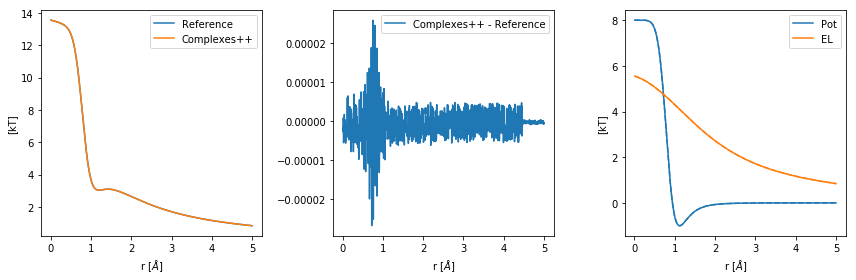

In [12]:
fig, axes = plt.subplots(ncols=3, figsize=plt.figaspect(1/3))

ax = axes[0]
ax.plot(x, softcore(x),  label='Reference')
ax.plot(x, stat['softcore-pot']+stat['softcore-el'], label='Complexes++')
ax.set(xlabel='r [$\AA$]', ylabel='[kT]',)
ax.legend()

ax = axes[1]
ax.plot(x, stat['softcore-pot']+stat['softcore-el'] - softcore(x),  label='Complexes++ - Reference')
ax.set(xlabel='r [$\AA$]', ylabel='',)
ax.legend()

ax = axes[2]
ax.plot(x, lennard_jones(x),  label='Pot', color='C0')
ax.plot(x, stat['softcore-pot'].values, color='C0', linestyle='--')
ax.plot(x, el_stat(x),  label='EL', color='C1')
ax.plot(x, stat['softcore-el'].values, color='C1', linestyle='--')
ax.set(xlabel='r [$\AA$]', ylabel='[kT]',)
ax.legend()

fig.tight_layout()

In [13]:
# store reference for unit test
np.savetxt('reference.dat', softcore(x))

# Generate test files 

In [1]:
%%writefile CMakeLists.txt
file(COPY "test.cplx" DESTINATION ${CMAKE_CURRENT_BINARY_DIR})
file(COPY "test.config" DESTINATION ${CMAKE_CURRENT_BINARY_DIR})
file(COPY "test.trr" DESTINATION ${CMAKE_CURRENT_BINARY_DIR})
file(COPY "test.py" DESTINATION ${CMAKE_CURRENT_BINARY_DIR})
file(COPY "run.sh" DESTINATION ${CMAKE_CURRENT_BINARY_DIR})
file(COPY "reference.dat" DESTINATION ${CMAKE_CURRENT_BINARY_DIR})

add_test(app-softcore-energy run.sh)

Overwriting CMakeLists.txt


In [15]:
%%writefile test.py
import sys
import pandas as pd
import numpy as np

stat = pd.read_csv('test.stat')
ref = np.loadtxt('reference.dat')

res = True
try:
    np.testing.assert_almost_equal(ref, stat['softcore-pot']+stat['softcore-el'], decimal=4)
except:
    res = False

print("all ok? = {}".format(res))
sys.exit(not res)

Overwriting test.py


In [16]:
%%writefile run.sh
#!/bin/bash

# stop on any error
set -e

function run {
    complexes=../../../src/complexes++
    $complexes -c test.config --rerun=True --nb-thread=1 --backup=false
}

function testit {
    python test.py
}


run
testit
res=$?
exit $res

Overwriting run.sh


In [17]:
!chmod +x run.sh